In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.optimize import curve_fit

def chi_squared(model_params, model, x_data, y_data, y_error):
    return(np.sum(((y_data - model(x_data, *model_params))/y_error)**2))

def reduced_chi_squared(Chi_squared, DoF):
    return Chi_squared / (DoF)

def Calibration_Index(file_name, sheet_names, column_names):

    ext = os.path.splitext(file_name)[1].lower()
    if ext == ".csv":
        raise ValueError("CSV files do not support multiple sheets")
    elif ext in [".xls", ".xlsx"]:
        pass
    else:
        raise ValueError("Unsupported file type")

    mean_peak_indices = []
    mean_peak_uncertainties =[]

    for s in range(len(sheet_names)):

        sheet_name = sheet_names[s]
        cols = column_names[s]

        df = pd.read_excel(file_name, sheet_name=sheet_name)
        df = df.dropna()

        amplitudes = [df[col] for col in cols]

        index_list = []
        for i in range(len(amplitudes[0])):
            index_list.append(i)

        max_intensity = [np.argmax(i) for i in amplitudes]

        plt.figure()
        for i in range(len(amplitudes)):
            plt.scatter(index_list, amplitudes[i],
                        label=cols[i], marker='o', s=3)

        plt.xlabel('Index')
        plt.ylabel('Intensity')
        plt.legend()
        plt.title(f"Sheet: {sheet_name}")
        plt.show()

        mean_peak_indices.append(np.mean(max_intensity))
        mean_peak_uncertainties.append(np.std(max_intensity)/np.sqrt(len(max_intensity)))

        print("----- Results -----")
        print(f"Sheet '{sheet_name}': mean peak index = {np.mean(max_intensity)}")
        print("----- ----- -----")

    return mean_peak_indices, mean_peak_uncertainties

def Calibration_Fitter(model, p0_model, start_index,
                       wavelengths, mean_indexes, uncertainties):

    dof = len(wavelengths) - len(p0_model)
    if len(mean_indexes) <= len(p0_model):
        raise ValueError("Not enough data points for number of fit parameters")

    if dof <= 0:
        raise ValueError("Degrees of freedom <= 0. Not enough data points.")

    mean_indexes = np.array(mean_indexes)
    wavelengths = np.array(wavelengths)
    uncertainties = np.array(uncertainties)

    # Sort by index
    order = np.argsort(mean_indexes)
    mean_indexes = mean_indexes[order]
    wavelengths = wavelengths[order]
    uncertainties = uncertainties[order]
    monochromator_uncertainties = uncertainties / 10

    monochromator_value = -mean_indexes/10 + start_index

    popt_model, cov_model = curve_fit(
        model,
        monochromator_value,
        wavelengths,
        sigma=monochromator_uncertainties,
        absolute_sigma=True,
        p0=p0_model
    )

    model_uncertainties = np.sqrt(np.diag(cov_model))

    chi2 = chi_squared(
        popt_model, model,
        monochromator_value, wavelengths,
        monochromator_uncertainties
    )
    Rchi2 = reduced_chi_squared(chi2, dof)

    plt.figure()
    plt.plot(monochromator_value,
             model(monochromator_value, *popt_model))
    plt.errorbar(monochromator_value, wavelengths,
                 yerr=monochromator_uncertainties,
                 fmt='o', ms=3)
    plt.xlabel('monochromator value')
    plt.ylabel('wavelength (nm)')
    plt.show()

    print('----- Results -----')
    print(f"gradient:  {popt_model[0]:.4f} ± {model_uncertainties[0]:.4f}")
    print(f"intercept: {popt_model[1]:.4f} ± {model_uncertainties[1]:.4f}")
    print(f"reduced chi^2: {Rchi2:.4f}")

    return popt_model, cov_model



def Full_Calibration(file_name,
                     sheet_names,
                     column_names,
                     model,
                     p0_model,
                     start_index,
                     wavelengths):

    mean_indexes, uncertainties = Calibration_Index(
        file_name=file_name,
        sheet_names=sheet_names,
        column_names=column_names
    )

    popt_model, cov_model = Calibration_Fitter(
        model=model,
        p0_model=p0_model,
        start_index=start_index,
        wavelengths=wavelengths,
        mean_indexes=mean_indexes,
        uncertainties=uncertainties
    )

    return popt_model, cov_model, mean_indexes, uncertainties


In [66]:
def model(x,A,B):
    return A*x + B

p0_model = [1,0]

wavelengths = [632.8, 543.5, 594.1 ]

sheets = ['Red', 'Green', 'Orange']
cols = [['R_A_1', 'R_A_2', 'R_A_3', 'R_A_4', 'R_A_5'],['G_A_1','G_A_2'],['O_A_1','O_A_2']]
file = "Trial.xlsx"

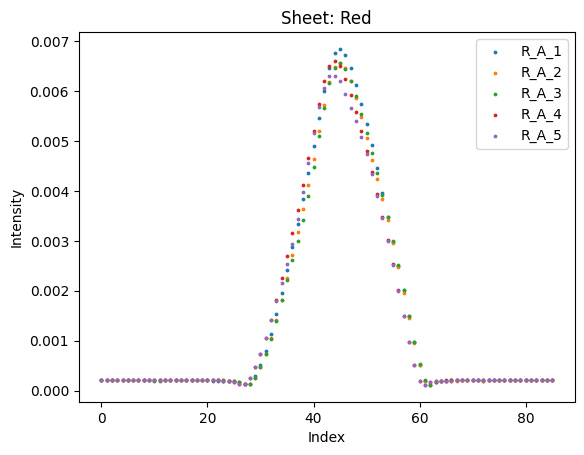

----- Results -----
Sheet 'Red': mean peak index = 44.4
----- ----- -----


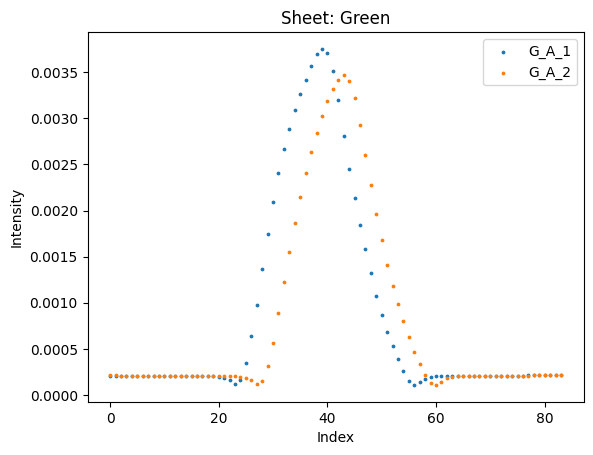

----- Results -----
Sheet 'Green': mean peak index = 41.0
----- ----- -----


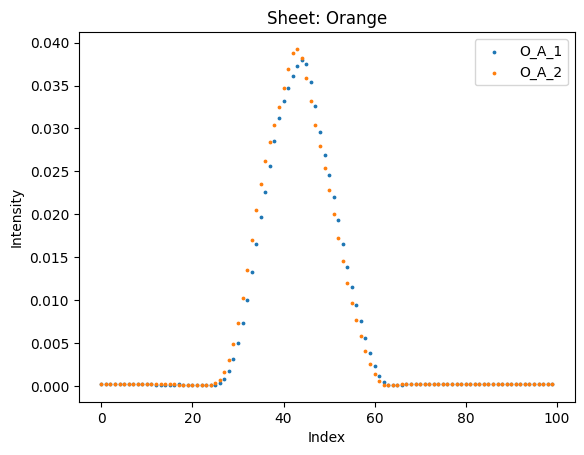

----- Results -----
Sheet 'Orange': mean peak index = 43.5
----- ----- -----


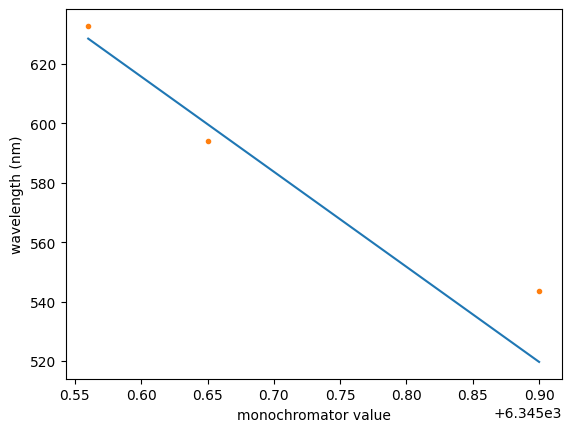

----- Results -----
gradient:  -320.3221 ± 0.3675
intercept: 2033251.8021 ± 2332.1115
reduced chi^2: 67851.5938


(array([-3.20322122e+02,  2.03325180e+06]),
 array([[ 1.35067613e-01, -8.57087014e+02],
        [-8.57087014e+02,  5.43874387e+06]]),
 [np.float64(44.4), np.float64(41.0), np.float64(43.5)],
 [np.float64(0.35777087639996635),
  np.float64(1.414213562373095),
  np.float64(0.35355339059327373)])

In [68]:
Full_Calibration(file_name=file,
                 sheet_names=sheets,
                 column_names=cols,
                 model=model,
                 p0_model=p0_model,
                 start_index=6350,
                 wavelengths=wavelengths
                 )